In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd 
import xgboost as xgb
import pickle

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder ,OrdinalEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Define Functions 

In [2]:
## function to show model metrics 
def scores(model, X_, y_):
    from sklearn.metrics import recall_score,accuracy_score, mean_absolute_error, classification_report, precision_score,roc_auc_score
    _y_prediction = model.predict(X_)
    print(len(_y_prediction))
    print("accuracy_score: ", accuracy_score(y_,_y_prediction))
    print("recall_score: ", recall_score(y_,_y_prediction))
    print("precision_score: ", precision_score(y_,_y_prediction))
    print("roc_auc_score: ", roc_auc_score(y_,_y_prediction))

In [234]:
# function to plot ROC scores 

def roc_plot(model, X_test, y_test):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    
    # No skill model
    ns_probs = [0 for _ in range(len(y_test))]


    # predict based on X_test
    probs =model.predict_proba(X_test)[:,1]

    # calculate scores based on y_test
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label= 'Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [547]:
def plot_PRCurve(model, X_test, y_test): 
    from sklearn.metrics import precision_recall_curve, f1_score, auc
    no_skill_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(X_test)
    # calculate precision and recall for each threshold
    ns_precision, ns_recall, _ = precision_recall_curve(y_test, no_skill_probs)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    precision = np.sum(y_test)/len(y_test)
    # calculate scores
    ns_f1, ns_auc = f1_score(y_test, no_skill_probs), auc(ns_recall, ns_precision)
    lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    print('No Skill: f1=%.3f auc=%.3f' % (ns_f1, ns_auc))
    print('Model: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    plt.plot([0,1], [precision,precision], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='model')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend(bbox_to_anchor=(1.05, 1))
    # show the plot
    plt.show()

In [244]:
precision

array([0.66666667, 0.5       , 1.        , 1.        ])

In [227]:
ns_recall

array([1., 0.])

In [224]:
ns_precision

array([0.07940064, 1.        ])

In [228]:
import numpy as np
from sklearn.metrics import precision_recall_curve
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)


In [230]:
thresholds

array([0.35, 0.4 , 0.8 ])

In [56]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Data Preparation

In [52]:
bikecl  = pd.read_csv("./data/bikecl_with_bikelane_updated_Oct3.csv", sep= ",")
#strt2 = pd.read_csv('./data/street_withlane_Oct5.csv', sep= ",")

In [53]:
strt2 = pd.read_csv('./data/street_bike_sidewalk_oct6.csv', sep= ",")
len(strt2)

23495

In [54]:
#Read file using gpd.read_file()
fp2 = "./data/Seattle_Streets/Seattle_Streets.shp"
street = gpd.read_file(fp2)

# filter out highway, 0 is non-artisial 
strt = street.loc[street['ARTCLASS'] < 4,].reset_index(drop = True).copy()

## remove road underconstruction or planned
Street_shp = strt.loc[(strt['STATUS'] != 'UNDERCONS') & (strt['STATUS'] != 'PLANNED'),:].reset_index(drop = True).copy()

In [55]:
strt2['street_index'] = strt2.index

In [56]:
## accident with positive examples 

positive_example = bikecl.merge(strt2, left_on = ['near_str_index'], right_on = ['street_index'] , how = 'left',
                               indicator = True)

#positive_example.loc[:,['near_str_index','bike_facility','index','EXISTING_FACILITY_TYPE']]

In [57]:
positive_example.groupby('bike_facility').size()

bike_facility
In Street, Major Separation     157
In Street, Minor Separation     820
Multi-use Trail                  49
Neighborhood Greenway            24
NoFacility                     4114
Sharrow                         543
dtype: int64

In [58]:
positive_example.loc[positive_example['accident_year'] < positive_example['bikelane_yr_complete'],'bike_facility'] 
## was already changed to nofacility 

8       NoFacility
26      NoFacility
32      NoFacility
41      NoFacility
57      NoFacility
           ...    
4669    NoFacility
4721    NoFacility
4762    NoFacility
4846    NoFacility
4948    NoFacility
Name: bike_facility, Length: 616, dtype: object

In [60]:
## zoning and neighbourhood information 
str_update = pd.read_csv('./data/str_neigh_zone_speed_oct6.csv')

In [61]:
str_update.head()

,COMPKEY,CLASS_DESC,CATEGORY_D,GEN_ALIAS,AREA_ACRES,TOTAL_POPU,HOUSEHOLDS,AWDT_18,AWDT_18_log
0,1006,Downtown,Downtown,Downtown Commercial Core,206.5,4260,2530,21000.0,9.952278
1,1009,Downtown,Downtown,Downtown Commercial Core,206.5,4260,2530,17800.0,9.786954
2,1032,Multi-Family,Lowrise Multi-Family,Queen Anne,1888.4,37283,19354,NaN,NaN
3,1051,Single Family,Single Family,Queen Anne,1888.4,37283,19354,NaN,NaN
4,1060,Single Family,Single Family,Queen Anne,1888.4,37283,19354,NaN,NaN


In [62]:

## only keey record that have spatial information. 40 don't have. 
positive = positive_example.loc[positive_example['COMPKEY_x'].notnull(),:].reset_index(drop = True).copy()

In [63]:
positive_all = positive.merge(str_update,left_on = 'COMPKEY_x', right_on = 'COMPKEY', how = 'left')

In [64]:
positive.isnull().sum()

Unnamed: 0                   0
OBJECTID_x_x                 0
INCKEY                       0
COLDETKEY                    0
REPORTNO                     0
STATUS_x                     0
ADDRTYPE                     0
INTKEY                    2419
LOCATION                     0
EXCEPTRSNC                5581
EXCEPTRSND                5581
SEVERITYCO                   1
SEVERITYDE                   0
COLLISIONT                  17
PERSONCOUN                   0
PEDCOUNT                     0
PEDCYLCOUN                   0
VEHCOUNT                     0
INJURIES                     0
SERIOUSINJ                   0
FATALITIES                   0
INCDATE                      0
INCDTTM                      0
JUNCTIONTY                  35
SDOT_COLCO                   0
SDOT_COLDE                   0
INATTENTIO                4782
UNDERINFL                    0
WEATHER                      6
ROADCOND                     5
LIGHTCOND                    7
PEDROWNOTG                3843
SDOTCOLN

In [65]:
len(positive_all)

5667

In [66]:
positive_all.to_csv('./data/bikecl_street_bike_info_oct6_withzone_neighbour_oct14.csv', sep = ',',)

In [286]:
positive_all.to_csv('./data/bikecl_street_bike_info_oct6_withzone_neighbour.csv', sep = ',',)

In [67]:
street = strt2.merge(str_update, left_on = 'COMPKEY_x', right_on = 'COMPKEY', how = 'left')


In [68]:
len(street)

23495

In [69]:
changedstreet_index = positive.loc[positive['accident_year'] < positive['bikelane_yr_complete'],'near_str_index'].reset_index(drop = True)

In [70]:
changedstreet_index = changedstreet_index.astype('int')
changedstreet_index = np.unique(changedstreet_index)

In [71]:
tempstr = street.iloc[changedstreet_index, :].reset_index(drop = True).copy() 
len(tempstr)

382

In [72]:
tempstr.groupby(['EXISTING_FACILITY_TYPE']).size()

EXISTING_FACILITY_TYPE
In Street, Major Separation     82
In Street, Minor Separation     98
Multi-use Trail                  6
Neighborhood Greenway           21
NoFacility                      47
Sharrow                        128
dtype: int64

In [73]:
tempstr2 = tempstr.loc[tempstr['EXISTING_FACILITY_TYPE'] != 'NoFacility', :].reset_index(drop = True).copy()
len(tempstr2)

335

In [74]:
tempstr2.iloc[:,-19]

0      In Street, Major Separation
1      In Street, Minor Separation
2      In Street, Minor Separation
3      In Street, Minor Separation
4                          Sharrow
5            Neighborhood Greenway
6                          Sharrow
7      In Street, Minor Separation
8                          Sharrow
9                          Sharrow
10     In Street, Major Separation
11     In Street, Major Separation
12           Neighborhood Greenway
13     In Street, Minor Separation
14                         Sharrow
15                         Sharrow
16                         Sharrow
17                         Sharrow
18     In Street, Minor Separation
19     In Street, Major Separation
20                         Sharrow
21     In Street, Minor Separation
22                         Sharrow
23                         Sharrow
24                         Sharrow
25                         Sharrow
26                         Sharrow
27     In Street, Major Separation
28                  

In [75]:
for i in np.arange(0,len(tempstr2)):
    tempstr2.iloc[i,-19] = 'NoFacility'

In [76]:
street_new = pd.concat([street, tempstr2],ignore_index = True)

In [77]:
street_new.isnull().sum()

OBJECTID_x                    0
ARTCLASS                      0
COMPKEY_x                     0
UNITIDSORT                    0
UNITDESC_x                    0
STNAME_ORD                    0
XSTRLO                        0
XSTRHI                        0
ARTDESCRIP                    0
OWNER                     23379
STATUS_street                44
BLOCKNBR                      0
SPEEDLIMIT                   28
SEGDIR                        1
ONEWAY                        4
ONEWAYDIR                 22452
FLOW                      22454
SEGLENGTH                     0
SURFACEWID                 3357
SURFACETYP                  896
SURFACET_1                23135
INTRLO                        2
DIRLO                         1
INTKEYLO                      2
INTRHI                        3
DIRHI                         1
NATIONHWYS                    0
STREETTYPE                  476
PVMTCONDIN                 4042
PVMTCOND_1                23135
TRANCLASS                     0
TRANDESC

In [78]:
street_new['SRTS_SIDEWALK_RANK'].unique()

array([ 3.,  1.,  4.,  2.,  0., nan])

In [79]:
street_new.loc[street_new['CONDITION'] == ' ' ,['CONDITION']] = np.nan


In [80]:
street_new['CONDITION'].astype('str')
street_new['CONDITION'].unique()

array(['FAIR', 'GOOD', 'POOR', 'VERY-POOR', nan, 'EXCELLENT'],
      dtype=object)

In [81]:
street_new.to_csv('./data/street_allinfor_Oct14.csv', sep = ',')
#street_new = pd.read_csv('./data/street_allinfor_Oct6.csv')

In [ ]:
street_new.to_csv('./data/street_allinfor_Oct6.csv', sep = ',')

In [82]:
positive = positive_all.drop(columns = ['EXISTING_FACILITY_TYPE'])

In [86]:
'EXISTING_FACILITY_TYPE' in positive.columns

True

In [85]:

positive = positive.rename(columns = {'bike_facility' : 'EXISTING_FACILITY_TYPE',
                                   'rushhour': 'simulate_rushhour',
                                    'weather_group2': 'simulate_weather',
                                   'weekday': 'simulate_weekday'
                                  })
#positive_example.columns

In [270]:
#positive_example.isnull().sum()

In [87]:
## increase street size to 2x to include rushhour, weekday, weather x2, x2,x2 
n = len(strt2) * 8 
#hour_list = pd.Series(np.arange(0,))
#type(hour_list)
#test = pd.concat([hour_list]*len(strt2), ignore_index = True) 

import random
#random.seed(9001)

simulate_street = pd.concat([street_new]*8, ignore_index = True)  

simulate_weather = np.random.choice(a=['Clear or Partly Cloudy', 'Raining'],  size= len(street_new)*8,  p=[0.58, 0.42], replace = True ) 
simulate_weekday = np.random.choice(a=[1,0],  size= len(street_new)*8,  p=[0.7, 0.3], replace = True ) 
simulate_rushhour = np.random.choice(a=[1,0],  size= len(street_new)*8,  p=[0.5, 0.5], replace = True ) 
simulate_street['simulate_weekday'] = simulate_weekday 
simulate_street['simulate_rushhour'] = simulate_rushhour 
simulate_street['simulate_weather'] = simulate_weather


In [88]:
#positive.loc[:,['LENGTH_MILES','bike_facility']]
positive.loc[positive.loc[:, 'EXISTING_FACILITY_TYPE'] == 'NoFacility',['LENGTH_MILES']] = 0

In [89]:
#n = 24 * len(strt2)
#temp = (np.zeros(int(n*0.5))).tolist() + (np.ones(n- int(n*0.5))).tolist()
#simulate_street = pd.concat([strt2]*24, ignore_index = True)  
#simulate_street['simulate_rushhour'] = temp


In [90]:
positive.drop(columns = ['_merge'], inplace = True)

In [91]:
positive.head()

,Unnamed: 0,OBJECTID_x_x,INCKEY,COLDETKEY,REPORTNO,STATUS_x,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNC,EXCEPTRSND,SEVERITYCO,SEVERITYDE,COLLISIONT,PERSONCOUN,PEDCOUNT,PEDCYLCOUN,VEHCOUNT,INJURIES,SERIOUSINJ,FATALITIES,INCDATE,INCDTTM,JUNCTIONTY,SDOT_COLCO,SDOT_COLDE,INATTENTIO,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTG,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKK,HITPARKEDC,geometry_x,near_str_index,min_length,weather_group,date,time,hour,dayofweek,simulate_weekday,simulate_rushhour,simulate_weather,min_length_cl_to_bike,min_index_cl_to_bike,cl_bike_match,OBJECTID_y_x,STREET_NAM,LENGTH_MIL,STATUS_y,COMPKEY_x,CATALYTIC_,NETWORK_x,DATE_COMPL,EXISTING_F,PLANNED_FA,PROJECT_NU,DATE_PLANN,DATE_EXPIR,SHAPE_Leng_x,geometry_y,index,EXISTING_FACILITY_TYPE,bikelane_yr_complete,accident_year,OBJECTID_x_y,ARTCLASS,COMPKEY_x,UNITIDSORT,UNITDESC_x,STNAME_ORD,XSTRLO,XSTRHI,ARTDESCRIP,OWNER,STATUS_street,BLOCKNBR,SPEEDLIMIT,SEGDIR,ONEWAY,ONEWAYDIR,FLOW,SEGLENGTH,SURFACEWID,SURFACETYP,SURFACET_1,INTRLO,DIRLO,INTKEYLO,INTRHI,DIRHI,NATIONHWYS,STREETTYPE,PVMTCONDIN,PVMTCOND_1,TRANCLASS,TRANDESCRI,SLOPE_PCT,PVMTCATEGO,PARKBOULEV,SHAPE_Leng_y,geometry,index_x,UNITDESC_y,STR,Side,CONDITION,CURBTYPE,CURRENT_STATUS,FILLERTYPE,FILLERWID,LENUOM,SW_WIDTH,MATL,SURFTYPE,SWINCOMPLETEYN,MULTIPLESURFACEYN,CURBRAMPHIGH,CURBRAMPMID,CURBRAMPLOW,SRTS_SIDEWALK_RANK,PRIMARYCROSSSLOPE,MINIMUMVARIABLEWIDTH,closest_bike_index,OBJECTID_y_y,STREET_NAME,LENGTH_MILES,STATUS_bike,COMPKEY_y,CATALYTIC_PROJECTS,NETWORK_y,DATE_COMPLETED,PLANNED_FACILITY_TYPE,PROJECT_NUMBER,DATE_PLANNED,DATE_EXPIRED,SHAPE_Length,index_y,SEGLENGTH_log,SURFACEWID_log,street_index,COMPKEY_y,CLASS_DESC,CATEGORY_D,GEN_ALIAS,AREA_ACRES,TOTAL_POPU,HOUSEHOLDS,AWDT_18,AWDT_18_log
0,0,1015,63600,63600,2188744,Matched,Intersection,35587.0,1ST AVE NW AND NW 143RD ST,NaN,NaN,2,Injury Collision,Cycles,2,0,1,1,1,0,0,2006-05-16T00:00:00.000Z,5/16/06 6:30,At Intersection (intersection related),51,PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT...,NaN,0,Clear or Partly Cloudy,Dry,Daylight,NaN,6136002.0,NaN,45.0,Vehicle - Pedalcyclist,0,0,N,POINT (1265176.677676335 270845.8969054073),2284.0,0.000000,Clear or Partly Cloudy,5/16/06,6:30:00,6.0,1,1,0.0,Clear or Partly Cloudy,2576.622861,1800.0,9999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoFacility,NaN,2006,2322.0,0.0,1182.0,251400.0,1ST AVE NW BETWEEN NW 140TH ST AND NW 143RD ST,1ST AVE NW,NW 140TH ST,NW 143RD ST,Not Designated,NaN,INSVC,14000.0,20.0,N,N,NaN,NaN,662.0,22.0,ST,NaN,1ST AVE NW AND NW 140TH ST,N,35593.0,1ST AVE NW AND NW 143RD ST,S,N,Neighborhood Yield Street,71.0,NaN,0.0,NOT DESIGNATED,4.0,NON-ART,N,661.927005,LINESTRING (1265163.643180326 270184.098248720...,3268.0,1ST AVE NW BETWEEN NW 140TH ST AND NW 143RD ST...,1ST AVE NW BETWEEN NW 140TH ST AND NW 143RD ST,E SIDE ...,,NONE,INSVC,NONE,0.0,Feet,0.0,,UIMPRV,N,N,U,U,U,2.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.495266,3.091042,2284.0,1182,Single Family,Single Family,Broadview/Bitter Lake,1478.5,13725,6790,NaN,NaN
1,1,1031,76900,76900,2620912,Matched,Intersection,29072.0,BROADWAY AND E HOWELL ST,NaN,NaN,2,Injury Collision,Cycles,2,0,1,1,1,0,0,2007-02-27T00:00:00.000Z,2/27/07 10:40,At Intersection (intersection related),18,"MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END A...",NaN,0,Clear or Partly Cloudy,Dry,Daylight,Y,7058004.0,NaN,45.0,Vehicle - Pedalcyclist,6828,0,N,POINT (1273573.179700941 228816.6565423608),11910.0,0.000000,Clear or Partly Cloudy,2/27/07,10:40:00,10.0,1,1,0.0,Clear or Partly Cloudy,0.000102,2722.0,9999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoFacility,NaN,2007,12063.0,2.0,9449.0,57350170.0,BROADWAY BETWEEN XW E OLIVE ST AND E HOWELL ST,BROADWAY,XW E OLIVE ST,E HOWELL ST,Minor Arterial,NaN,INSVC,1700.0,25.0,N,N,NaN,NaN,426.0,52.0,AC/PCC,NaN,BROADWAY AND XW E OLIVE ST,N,29731.0,BROADWAY AND E HOWELL ST,S,N,Urban Village Neighborhood,45.0,NaN,2.0,MAJOR TRANSIT ROUTE,2.0,ART,N,426.060321,

In [92]:
simulate_street.groupby('GEN_ALIAS').size()

GEN_ALIAS
Alki/Admiral                              3360
Arbor Heights                             2008
Ballard                                   2024
Beacon Hill                               3208
Belltown                                  1072
Broadview/Bitter Lake                     3232
Capitol Hill                              2592
Cascade/Eastlake                          3624
Cedar Park/Meadowbrook                    2688
Central Area/Squire Park                  4024
Columbia City                             5296
Downtown Commercial Core                  1576
Duwamish/SODO                             4552
Fauntleroy/Seaview                        4400
First Hill                                2160
Fremont                                   5336
Georgetown                                2160
Green Lake                                4584
Greenwood/Phinney Ridge                   6208
Haller Lake                               2576
High Point                                1016
Hig

In [93]:
simulate_street = simulate_street.rename(columns = {'LENGTH_MILES' : 'LENGTH_MIL'})

In [94]:
positive.head()

,Unnamed: 0,OBJECTID_x_x,INCKEY,COLDETKEY,REPORTNO,STATUS_x,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNC,EXCEPTRSND,SEVERITYCO,SEVERITYDE,COLLISIONT,PERSONCOUN,PEDCOUNT,PEDCYLCOUN,VEHCOUNT,INJURIES,SERIOUSINJ,FATALITIES,INCDATE,INCDTTM,JUNCTIONTY,SDOT_COLCO,SDOT_COLDE,INATTENTIO,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTG,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKK,HITPARKEDC,geometry_x,near_str_index,min_length,weather_group,date,time,hour,dayofweek,simulate_weekday,simulate_rushhour,simulate_weather,min_length_cl_to_bike,min_index_cl_to_bike,cl_bike_match,OBJECTID_y_x,STREET_NAM,LENGTH_MIL,STATUS_y,COMPKEY_x,CATALYTIC_,NETWORK_x,DATE_COMPL,EXISTING_F,PLANNED_FA,PROJECT_NU,DATE_PLANN,DATE_EXPIR,SHAPE_Leng_x,geometry_y,index,EXISTING_FACILITY_TYPE,bikelane_yr_complete,accident_year,OBJECTID_x_y,ARTCLASS,COMPKEY_x,UNITIDSORT,UNITDESC_x,STNAME_ORD,XSTRLO,XSTRHI,ARTDESCRIP,OWNER,STATUS_street,BLOCKNBR,SPEEDLIMIT,SEGDIR,ONEWAY,ONEWAYDIR,FLOW,SEGLENGTH,SURFACEWID,SURFACETYP,SURFACET_1,INTRLO,DIRLO,INTKEYLO,INTRHI,DIRHI,NATIONHWYS,STREETTYPE,PVMTCONDIN,PVMTCOND_1,TRANCLASS,TRANDESCRI,SLOPE_PCT,PVMTCATEGO,PARKBOULEV,SHAPE_Leng_y,geometry,index_x,UNITDESC_y,STR,Side,CONDITION,CURBTYPE,CURRENT_STATUS,FILLERTYPE,FILLERWID,LENUOM,SW_WIDTH,MATL,SURFTYPE,SWINCOMPLETEYN,MULTIPLESURFACEYN,CURBRAMPHIGH,CURBRAMPMID,CURBRAMPLOW,SRTS_SIDEWALK_RANK,PRIMARYCROSSSLOPE,MINIMUMVARIABLEWIDTH,closest_bike_index,OBJECTID_y_y,STREET_NAME,LENGTH_MILES,STATUS_bike,COMPKEY_y,CATALYTIC_PROJECTS,NETWORK_y,DATE_COMPLETED,PLANNED_FACILITY_TYPE,PROJECT_NUMBER,DATE_PLANNED,DATE_EXPIRED,SHAPE_Length,index_y,SEGLENGTH_log,SURFACEWID_log,street_index,COMPKEY_y,CLASS_DESC,CATEGORY_D,GEN_ALIAS,AREA_ACRES,TOTAL_POPU,HOUSEHOLDS,AWDT_18,AWDT_18_log
0,0,1015,63600,63600,2188744,Matched,Intersection,35587.0,1ST AVE NW AND NW 143RD ST,NaN,NaN,2,Injury Collision,Cycles,2,0,1,1,1,0,0,2006-05-16T00:00:00.000Z,5/16/06 6:30,At Intersection (intersection related),51,PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT...,NaN,0,Clear or Partly Cloudy,Dry,Daylight,NaN,6136002.0,NaN,45.0,Vehicle - Pedalcyclist,0,0,N,POINT (1265176.677676335 270845.8969054073),2284.0,0.000000,Clear or Partly Cloudy,5/16/06,6:30:00,6.0,1,1,0.0,Clear or Partly Cloudy,2576.622861,1800.0,9999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoFacility,NaN,2006,2322.0,0.0,1182.0,251400.0,1ST AVE NW BETWEEN NW 140TH ST AND NW 143RD ST,1ST AVE NW,NW 140TH ST,NW 143RD ST,Not Designated,NaN,INSVC,14000.0,20.0,N,N,NaN,NaN,662.0,22.0,ST,NaN,1ST AVE NW AND NW 140TH ST,N,35593.0,1ST AVE NW AND NW 143RD ST,S,N,Neighborhood Yield Street,71.0,NaN,0.0,NOT DESIGNATED,4.0,NON-ART,N,661.927005,LINESTRING (1265163.643180326 270184.098248720...,3268.0,1ST AVE NW BETWEEN NW 140TH ST AND NW 143RD ST...,1ST AVE NW BETWEEN NW 140TH ST AND NW 143RD ST,E SIDE ...,,NONE,INSVC,NONE,0.0,Feet,0.0,,UIMPRV,N,N,U,U,U,2.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.495266,3.091042,2284.0,1182,Single Family,Single Family,Broadview/Bitter Lake,1478.5,13725,6790,NaN,NaN
1,1,1031,76900,76900,2620912,Matched,Intersection,29072.0,BROADWAY AND E HOWELL ST,NaN,NaN,2,Injury Collision,Cycles,2,0,1,1,1,0,0,2007-02-27T00:00:00.000Z,2/27/07 10:40,At Intersection (intersection related),18,"MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END A...",NaN,0,Clear or Partly Cloudy,Dry,Daylight,Y,7058004.0,NaN,45.0,Vehicle - Pedalcyclist,6828,0,N,POINT (1273573.179700941 228816.6565423608),11910.0,0.000000,Clear or Partly Cloudy,2/27/07,10:40:00,10.0,1,1,0.0,Clear or Partly Cloudy,0.000102,2722.0,9999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoFacility,NaN,2007,12063.0,2.0,9449.0,57350170.0,BROADWAY BETWEEN XW E OLIVE ST AND E HOWELL ST,BROADWAY,XW E OLIVE ST,E HOWELL ST,Minor Arterial,NaN,INSVC,1700.0,25.0,N,N,NaN,NaN,426.0,52.0,AC/PCC,NaN,BROADWAY AND XW E OLIVE ST,N,29731.0,BROADWAY AND E HOWELL ST,S,N,Urban Village Neighborhood,45.0,NaN,2.0,MAJOR TRANSIT ROUTE,2.0,ART,N,426.060321,

In [95]:
#full['acc'] = [ 1 if i == 'both' else 0 for i in full['_merge']]

In [96]:
numeric_features = ['SEGLENGTH_log','SURFACEWID_log', 'PVMTCONDIN', 'PVMTCOND_1','SLOPE_PCT' ,
                    'SW_WIDTH' ,'FILLERWID','MINIMUMVARIABLEWIDTH', 'PRIMARYCROSSSLOPE', 'LENGTH_MIL'] #10
#categorical_features = ['ARTCLASS', 'SEGDIR', 'ONEWAY', 'SURFACETYP','NATIONHWYS' ,'PVMTCATEGO', 'PARKBOULEV' ,'TRANDESCRI', 'rushhour']
categorical_features = ['SPEEDLIMIT','SEGDIR', 'STREETTYPE','ONEWAY', 'SURFACETYP','PVMTCATEGO',  
'CONDITION', 'SWINCOMPLETEYN', 'simulate_rushhour','simulate_weather','simulate_weekday', \
                        'EXISTING_FACILITY_TYPE','CLASS_DESC',  'GEN_ALIAS'] #14
new = ['SRTS_SIDEWALK_RANK','ARTCLASS'] 
#'MATL' , 'FILLERTYPE', 'CURBTYPE','NATIONHWYS' ,'PARKBOULEV'

In [97]:
len(categorical_features) + len(numeric_features ) + 5

29

In [98]:
positive_data = positive[numeric_features + categorical_features + new].copy()

In [99]:
positive_data['acc'] = 1 

In [100]:
negative_data = simulate_street[numeric_features + categorical_features+ new].copy()
negative_data['acc'] = 0 

In [101]:
X = pd.concat([positive_data, negative_data])

In [103]:
## drop dupulicats so all scenarios from positive examples are moved 
X_temp = X.drop_duplicates(subset  = [numeric_features+ categorical_features][0], keep = False, inplace = False)

In [104]:
X_negative  = X_temp.loc[X_temp.loc[:,'acc'] == 0,:]

In [105]:
## add in positive examples again 
X_both = pd.concat([positive_data, X_negative ])

In [106]:
X_both.groupby('acc').size()

acc
0    66029
1     5667
dtype: int64

In [107]:
65735/5667

11.599611787541908

In [108]:
y = X_both['acc']

In [109]:
X_both.drop(columns = ['acc'], inplace = True)

In [114]:
X_both.columns

Index(['SEGLENGTH_log', 'SURFACEWID_log', 'PVMTCONDIN', 'PVMTCOND_1', 'SLOPE_PCT', 'SW_WIDTH', 'FILLERWID', 'MINIMUMVARIABLEWIDTH', 'PRIMARYCROSSSLOPE', 'LENGTH_MIL', 'SPEEDLIMIT', 'SEGDIR', 'STREETTYPE', 'ONEWAY', 'SURFACETYP', 'PVMTCATEGO', 'CONDITION', 'SWINCOMPLETEYN', 'simulate_rushhour', 'simulate_weather', 'simulate_weekday', 'EXISTING_FACILITY_TYPE', 'CLASS_DESC', 'GEN_ALIAS', 'SRTS_SIDEWALK_RANK', 'ARTCLASS'], dtype='object')

In [112]:
y.to_csv('./data/label_oct14.csv', sep = ',', index= False, header = True)
X_both.to_csv('./data/training_oct14.csv', sep = ',', index= False, header = True)

In [115]:
X_both.loc[X_both['CONDITION'] == ' ', ['CONDITION']] = np.nan

In [18]:
y = pd.read_csv('./data/label_Oct12.csv', sep = ',')
X_both = pd.read_csv('./data/training_Oct12.csv', sep = ',')

# Model

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_both, y, stratify = y,test_size=0.1, shuffle = True, random_state = 42)

In [7]:
y_train = y_train.astype('int')

In [8]:
np.sum(y_train)/len(y_train)

acc    0.079364
dtype: float64

In [13]:
# initial parameters
#RANDOM_STATE = 42
#RATIO = 0.1
#K_FOLD = 5
from sklearn.model_selection import StratifiedKFold
K_FOLD = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#K_FOLD = StratifiedKFold(n_splits=3,shuffle=True)

# Logistic Regression


In [341]:
numeric_features = ['SEGLENGTH_log','SURFACEWID_log', 'PVMTCONDIN','SLOPE_PCT' ,
                    'SW_WIDTH' ,'LENGTH_MIL']
#'ARTCLASS'
#'PVMTCOND_1', 'PRIMARYCROSSSLOPE','MINIMUMVARIABLEWIDTH','FILLERWID'
#categorical_features = ['ARTCLASS', 'SEGDIR', 'ONEWAY', 'SURFACETYP','NATIONHWYS' ,'PVMTCATEGO', 'PARKBOULEV' ,'TRANDESCRI', 'rushhour']
categorical_features = ['STREETTYPE', 'PVMTCATEGO',\
                        'EXISTING_FACILITY_TYPE','CLASS_DESC']
ordinal_features = ['SPEEDLIMIT', 'CONDITION','ONEWAY',\
                   'simulate_rushhour','simulate_weather','simulate_weekday']
#'MATL' , 'FILLERTYPE', 'CURBTYPE','NATIONHWYS' ,'PARKBOULEV' , 'MINIMUMVARIABLEWIDTH' ,

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, fbeta_score
## pre-processing 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())])

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

In [343]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


## pre-processing 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])



In [346]:

from sklearn.feature_selection import SelectFromModel

log2 = LogisticRegression(solver='liblinear', class_weight = 'balanced')
logReg2 = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', log2)])

#      ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1", class_weight = 'balanced', solver='liblinear'))),

In [347]:
## cross validate 
from sklearn.model_selection import cross_validate
#scores = cross_validate(logReg2, X_train, y_train, scoring=['roc_auc','recall','accuracy','precision'], cv = K_FOLD, return_train_score= True, return_estimator=True)
#scores

In [348]:
## Grid Search 

from sklearn.model_selection import GridSearchCV
params = {
    'penalty': ['l1','l2'],
    'C': [0.001, 0.01, 0.1, 1,10,100],
     'class_weight': ['balanced']
}
new_params = {'classifier__' + key: params[key] for key in params}
ftwo_scorer = make_scorer(fbeta_score,beta = 2)

grid_lg_balance = GridSearchCV(logReg2, param_grid=new_params, cv=K_FOLD, scoring=ftwo_scorer, return_train_score=True)
grid_lg_balance.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                               

In [350]:
grid_lg_balance.best_params_

{'classifier__C': 100,
 'classifier__class_weight': 'balanced',
 'classifier__penalty': 'l1'}

In [351]:
scores(grid_lg_balance,X_train, y_train )

64526
accuracy_score:  0.7611195487090475
recall_score:  0.7841176470588235
precision_score:  0.2183813892529489
 roc_auc_score:  0.771631737742046


In [352]:
scores(grid_lg_balance,X_test, y_test )

7170
accuracy_score:  0.7651324965132497
recall_score:  0.7760141093474426
precision_score:  0.22033049574361543
 roc_auc_score:  0.7701061005619538


No Skill: ROC AUC=0.500
Model: ROC AUC=0.841


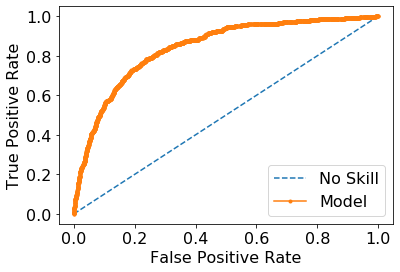

In [353]:
roc_plot(grid_lg_balance, X_test, y_test)

In [358]:
filename = './Results/grid_lg_balance.sav'
pickle.dump(grid_lg_balance.best_estimator_, open(filename, 'wb'))

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


No Skill: f1=0.000 auc=0.540
Model: f1=0.342 auc=0.355


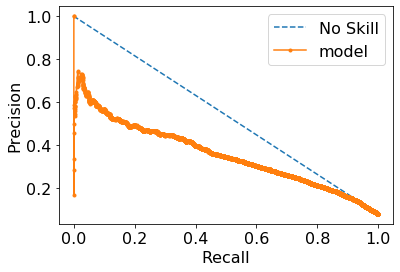

In [355]:
plot_PRCurve(grid_lg_balance,X_train, y_train)

# XGBoost

In [21]:
# re_group variables , remove #ARTCLASS

numeric_features = ['SEGLENGTH_log','SURFACEWID_log', 'PVMTCONDIN','SLOPE_PCT' ,
                    'SW_WIDTH' ,'LENGTH_MIL']
#'ARTCLASS'
#'PVMTCOND_1', 'PRIMARYCROSSSLOPE','MINIMUMVARIABLEWIDTH','FILLERWID'
#categorical_features = ['ARTCLASS', 'SEGDIR', 'ONEWAY', 'SURFACETYP','NATIONHWYS' ,'PVMTCATEGO', 'PARKBOULEV' ,'TRANDESCRI', 'rushhour']
categorical_features = ['STREETTYPE', 'PVMTCATEGO',\
                        'EXISTING_FACILITY_TYPE','CLASS_DESC']
ordinal_features = ['SPEEDLIMIT', 'CONDITION','ONEWAY',\
                   'simulate_rushhour','simulate_weather','simulate_weekday']
#'MATL' , 'FILLERTYPE', 'CURBTYPE','NATIONHWYS' ,'PARKBOULEV' , 'MINIMUMVARIABLEWIDTH' ,

In [22]:
##  XGboost ordinal variable ,remove #ARTCLASS
import xgboost as xgb
from sklearn.metrics import make_scorer, fbeta_score
## pre-processing 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())])

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgboost = make_pipeline(preprocessor,xgb_model)

params = {"learning_rate"    : [0.01, 0.05, 0.10, 0.15, 0.20 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] ,
         "reg_alpha"    : [ 1, 10, 100, 1000, 10000],
         "scale_pos_weight" : [8,10,12,15] }

new_params = {'xgbclassifier__' + key: params[key] for key in params}




In [138]:
#xg_ord = RandomizedSearchCV(xgboost, param_distributions =new_params, cv=K_FOLD, scoring='recall', return_train_score=True, n_iter = 10)
#xg_ord.fit(X_train, y_train)

ftwo_scorer = make_scorer(fbeta_score,beta = 2)
xg_beta = RandomizedSearchCV(xgboost, param_distributions =new_params, cv=K_FOLD, scoring=ftwo_scorer, return_train_score=True, n_iter = 10)
xg_beta.fit(X_train, y_train)

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', a

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indic

In [139]:
xg_beta.best_score_

0.6546146540088905

In [494]:
xg_beta.predict(X_train).sum()

10586

In [495]:
107/(107+460)

0.18871252204585537

In [534]:
## change threshold 
y_predict_adjusted = [1 if i >0.4 else 0 for i in xg_beta.predict_proba(X_test)[:,1]] 

In [535]:
cm = confusion_matrix(y_test, y_predict_adjusted)
cm

array([[5609,  965],
       [  92,  475]])

In [536]:
#scores(xg_beta, X_test, y_test)

In [544]:
# False negative
cm[1,0]/(cm[1,0]+cm[1,1])

0.16225749559082892

In [543]:
#false positive 
cm[0,1]/(cm[0,1]+ cm[0,0])

0.14679038637055064

In [539]:
# % positives 
(cm[0,1]+cm[1,1])/7147

0.20148313977892823

In [540]:
fbeta_score( y_test, xg_beta.predict(X_test), beta = 2)

0.6633977502163253

In [541]:
fbeta_score( y_test, y_predict_adjusted, beta = 2) 

0.6405070118662352

In [542]:
from sklearn.metrics import precision_score, recall_score,roc_auc_score, accuracy_score
print(precision_score(y_test, y_predict_adjusted))
print(accuracy_score(y_test, y_predict_adjusted))
print(recall_score(y_test, y_predict_adjusted))

0.3298611111111111
0.8519815151939504
0.8377425044091711


In [524]:
xg_beta

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

In [324]:
cm = confusion_matrix(y_train, xg_mat.predict(X_train))
cm

array([[53035,  6126],
       [  196,  4904]])

In [202]:
5644/(5644+53517)

0.09540068626290969

In [ ]:
158/(158+4942)

In [192]:
#false positive 
739/(739+5835)

0.11241253422573776

In [187]:
10586/len(X_train)

0.1647344423522821

In [ ]:
xg_beta.predict_proba[xg_beta.predict(X_train) == 0]

In [338]:
y_test_ = np.asarray(y_test.iloc[:,0])

In [388]:


#ftwo_scorer = make_scorer(fbeta_score,beta = 2)
xg_f1 = RandomizedSearchCV(xgboost, param_distributions =new_params, cv=K_FOLD, scoring='f1', return_train_score=True, n_iter = 10)
xg_f1.fit(X_train, y_train)

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metric

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_ind

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


No Skill: f1=0.000 auc=0.540
Model: f1=0.480 auc=0.637


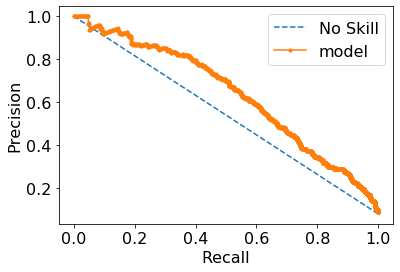

In [402]:
plot_PRCurve(xg_f1, X_test, y_test)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.924


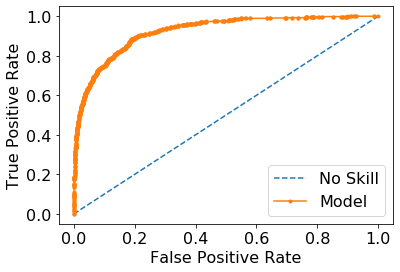

In [403]:
roc_plot(xg_f1, X_test, y_test)

<module 'matplotlib.pyplot' from '//anaconda3/envs/bike/lib/python3.7/site-packages/matplotlib/pyplot.py'>

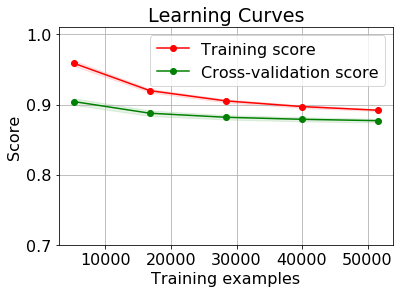

In [409]:

title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

plot_learning_curve(xg_f1.best_estimator_['xgbclassifier'], title, xg_f1.best_estimator_['columntransformer'].transform(X_train), y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [25]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef
matthews_scorer = make_scorer(matthews_corrcoef)
xg_mat = RandomizedSearchCV(xgboost, param_distributions =new_params, cv=K_FOLD, scoring=matthews_scorer, return_train_score=True, n_iter = 10)
xg_mat.fit(X_train, y_train)

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indic

In [64]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef,average_precision_score
aps_scorer = make_scorer(average_precision_score)
xg_aps = RandomizedSearchCV(xgboost, param_distributions =new_params, cv=K_FOLD, scoring= aps_scorer, return_train_score=True, n_iter = 10)
xg_aps.fit(X_train, y_train)

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indic

In [106]:

scores(xg_aps, X_test, y_test)

7141
accuracy_score:  0.9106567707603977
recall_score:  0.763668430335097
precision_score:  0.4621131270010672
roc_auc_score:  0.8435013888821818


In [155]:
xg_aps.best_score_

0.3604029918983853

In [83]:
average_precision_score(y_test, xg_aps.predict_proba(X_test)[:,1])

0.6967469516673822

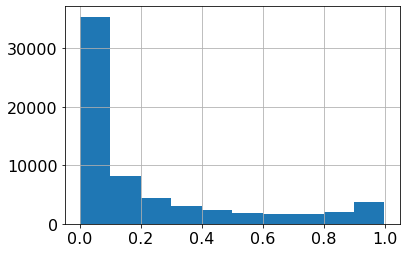

In [114]:
pd.Series(xg_mat.predict_proba(X_train)[:,1]).hist()

In [81]:
xg_aps.predict_proba(X_test)

array([[0.96586895, 0.03413107],
       [0.72731364, 0.2726864 ],
       [0.9953476 , 0.00465238],
       ...,
       [0.9770515 , 0.02294847],
       [0.9719873 , 0.02801267],
       [0.9362696 , 0.06373044]], dtype=float32)

In [93]:
xg_aps.best_params_

{'xgbclassifier__scale_pos_weight': 8,
 'xgbclassifier__reg_alpha': 10,
 'xgbclassifier__min_child_weight': 7,
 'xgbclassifier__max_depth': 10,
 'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__gamma': 0.4,
 'xgbclassifier__colsample_bytree': 0.4}

In [177]:
xg_beta.best_params_

{'xgbclassifier__scale_pos_weight': 15,
 'xgbclassifier__reg_alpha': 1,
 'xgbclassifier__min_child_weight': 3,
 'xgbclassifier__max_depth': 8,
 'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__gamma': 0.0,
 'xgbclassifier__colsample_bytree': 0.4}

In [68]:
scores(xg_aps, X_test, y_test)

7141
accuracy_score:  0.9106567707603977
recall_score:  0.763668430335097
precision_score:  0.4621131270010672
roc_auc_score:  0.8435013888821818


//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


No Skill: f1=0.000 auc=0.540
Model: f1=0.576 auc=0.697


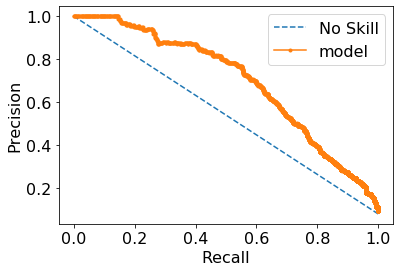

In [99]:
plot_PRCurve(xg_aps, X_test, y_test)

In [30]:
scores(xg_mat, X_test, y_test)

7141
accuracy_score:  0.8776081781263129
recall_score:  0.8112874779541446
precision_score:  0.37489812550937246
roc_auc_score:  0.8473078704039053


No Skill: f1=0.000 auc=0.540
Model: f1=0.513 auc=0.694


//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


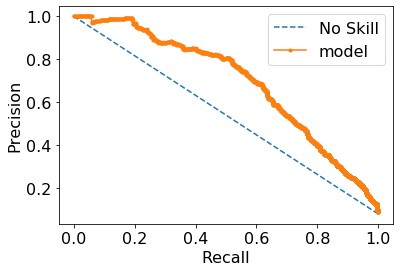

In [103]:
plot_PRCurve(xg_mat, X_test, y_test)

In [124]:
matthews_corrcoef(y_test, xg_mat.predict(X_test))

0.49783801755207696

No Skill: ROC AUC=0.500
Model: ROC AUC=0.933


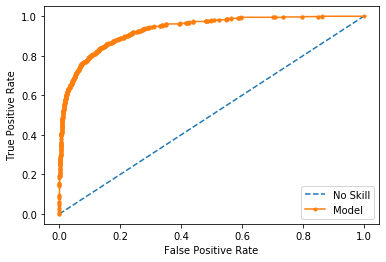

In [32]:
roc_plot(xg_mat, X_test, y_test)

In [47]:
cat_name  = xg_mat.best_estimator_.named_steps['columntransformer'].transformers_[1][1].named_steps['onehot'].get_feature_names()
featurename = np.array(np.concatenate(( np.array(numeric_features), cat_name, ordinal_features)))

In [96]:
xg_mat.best_params_

{'xgbclassifier__scale_pos_weight': 15,
 'xgbclassifier__reg_alpha': 1,
 'xgbclassifier__min_child_weight': 7,
 'xgbclassifier__max_depth': 8,
 'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__gamma': 0.3,
 'xgbclassifier__colsample_bytree': 0.4}

In [122]:
xg_mat.best_score_

0.4971915014501097

In [48]:
f_imp = xg_mat.best_estimator_['xgbclassifier'].feature_importances_

In [49]:
categorical_features

['STREETTYPE', 'PVMTCATEGO', 'EXISTING_FACILITY_TYPE', 'CLASS_DESC']

In [50]:
#f_imp

for i in np.arange(0,len(featurename)):
    featurename[i] = featurename[i].\
      replace('x0_', 'StreetType_').replace('x1_', 'StreetClass_').replace('x2_', 'BikeFacilities_').\
      replace('x3_', 'Zoning_').\
      replace('SPEEDLIMIT', 'SpeedLimlit').replace('simulate_weekday', 'Weekday').\
      replace('SURFACEWID_log', 'StreetWidth').replace('simulate_weather', 'Weather').\
      replace('NON-ART', 'Non-Arterial').replace('ART', 'Arterial').replace('SW_WIDTH', 'SidewalkWidth').\
    replace('MLTUSETRL', 'Multiuse').replace('simulate_rushhour', 'RushHour')
    
        
        
#print(featurename)


Text(0.5, 1.0, 'XGBoost Feature Importance')

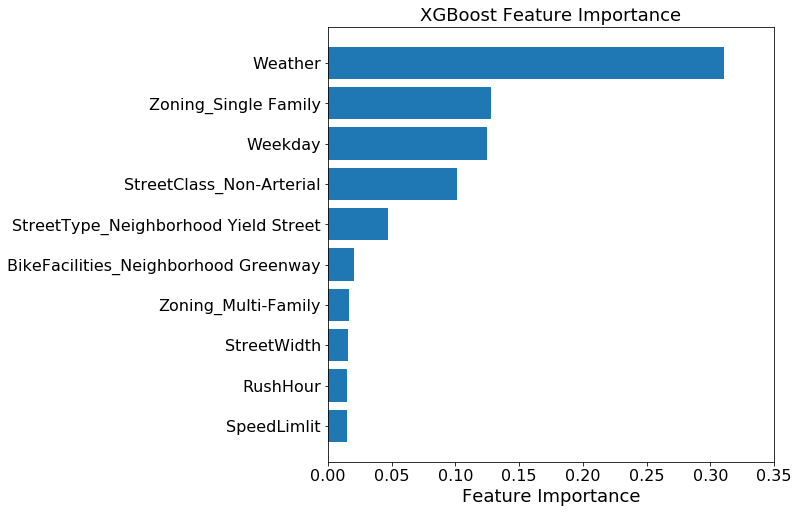

In [51]:
feat_imp = pd.DataFrame({
    'Feature': featurename[np.argsort(f_imp)[-10:]],
    'Importance': np.sort(f_imp)[-10:]
}).sort_values('Importance', ascending=False)

plt.rc('font', size=16)  
plt.figure(figsize=(8,8))
plt.barh(y = feat_imp['Feature'], width=feat_imp['Importance'][-10:])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance',  fontsize=18)
plt.xticks(np.arange(0, 0.40, 0.05))
plt.title('XGBoost Feature Importance', fontsize=18)
#plt.savefig('Feature Importance_xgboost.png')

<module 'matplotlib.pyplot' from '//anaconda3/envs/bike/lib/python3.7/site-packages/matplotlib/pyplot.py'>

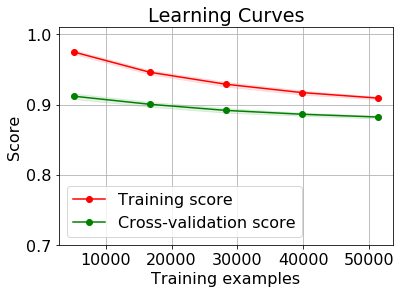

In [60]:
title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

plot_learning_curve(xg_mat.best_estimator_['xgbclassifier'], title, xg_mat.best_estimator_['columntransformer'].transform(X_train), y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [ ]:
title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

plot_learning_curve(xg_f1.best_estimator_['classifier'], title, xg_f1.best_estimator_['preprocessor'].transform(X_train), y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [329]:
xg_beta.best_params_

{'xgbclassifier__scale_pos_weight': 8,
 'xgbclassifier__reg_alpha': 100,
 'xgbclassifier__min_child_weight': 3,
 'xgbclassifier__max_depth': 10,
 'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__gamma': 0.2,
 'xgbclassifier__colsample_bytree': 0.5}

In [153]:
scores(xg_beta, X_train, y_train)

64261
accuracy_score:  0.9097119559297241
recall_score:  0.9690196078431372
precision_score:  0.46684300018892877
roc_auc_score:  0.9368094607901138


In [154]:
scores(xg_beta, X_test, y_test)

7141
accuracy_score:  0.8815291975913737
recall_score:  0.8112874779541446
precision_score:  0.38365304420350294
roc_auc_score:  0.8494374718642034


In [183]:
scores(xg_beta3, X_train, y_train)
scores(xg_beta3, X_test, y_test)

64526
accuracy_score:  0.8398784985897157
recall_score:  0.9060784313725491
precision_score:  0.31926212518999586
 roc_auc_score:  0.8701377920669834
7170
accuracy_score:  0.8267782426778243
recall_score:  0.8589065255731922
precision_score:  0.29533050333535477
 roc_auc_score:  0.8414629553505821


In [184]:
scores(xg_beta4, X_train, y_train)
scores(xg_beta4, X_test, y_test)

64526
accuracy_score:  0.81295911725506
recall_score:  0.8790196078431373
precision_score:  0.2813304047693756
 roc_auc_score:  0.8431546731707188
7170
accuracy_score:  0.803486750348675
recall_score:  0.8589065255731922
precision_score:  0.2681718061674009
 roc_auc_score:  0.8288171882750105


In [211]:
filename = './Results/xg_beta_oct14.sav'
#pickle.dump(xg_beta.best_estimator_, open(filename, 'wb'))
#xg_ord = pickle.load(open(filename, 'rb'))
xg_beta = pickle.load(open(filename, 'rb'))

In [178]:
filename = './Results/xg_mat_Oct17.sav'
pickle.dump(xg_mat.best_estimator_, open(filename, 'wb'))
#xg_ord = pickle.load(open(filename, 'rb'))
#xg_beta = pickle.load(open(filename, 'rb'))

In [179]:
filename = './Results/xg_aps_Oct17.sav'
pickle.dump(xg_aps.best_estimator_, open(filename, 'wb'))
#xg_ord = pickle.load(open(filename, 'rb'))
#xg_beta = pickle.load(open(filename, 'rb'))

No Skill: ROC AUC=0.500
Model: ROC AUC=0.932


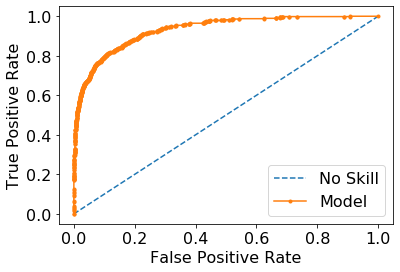

In [144]:
roc_plot(xg_beta, X_test, y_test)
#plt.savefig('ROC_xgboost_ord.png')

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


No Skill: f1=0.000 auc=0.540
Model: f1=0.521 auc=0.699


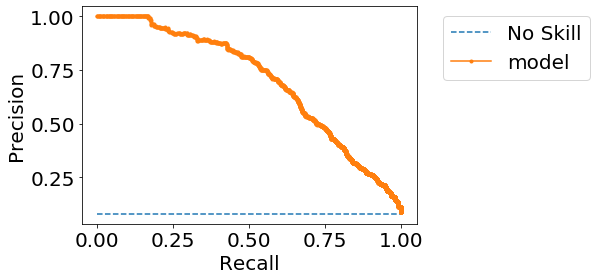

In [548]:
plot_PRCurve(xg_beta, X_test, y_test)
#plt.savefig('ROC_xgboost_beta.png')

In [253]:
fbeta_score( y_test, xg_beta.predict(X_test), beta = 2)

0.6633977502163253

In [163]:
cat_name  = xg_beta.best_estimator_.named_steps['columntransformer'].transformers_[1][1].named_steps['onehot'].get_feature_names()

In [164]:
cat_name  = xg_beta.best_estimator_.named_steps['columntransformer'].transformers_[1][1].named_steps['onehot'].get_feature_names()
featurename = np.array(np.concatenate(( np.array(numeric_features), cat_name, ordinal_features)))

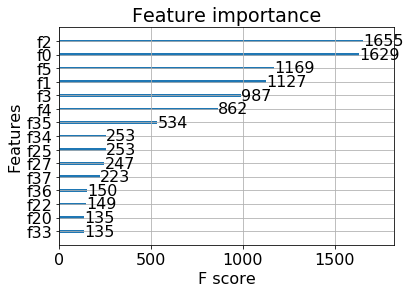

In [165]:
from xgboost import plot_importance 
plot_importance(xg_beta.best_estimator_['xgbclassifier'],max_num_features = 15) #, 


In [166]:
f_imp = xg_beta.best_estimator_['xgbclassifier'].feature_importances_

In [167]:
categorical_features

['STREETTYPE', 'PVMTCATEGO', 'EXISTING_FACILITY_TYPE', 'CLASS_DESC']

In [168]:
#f_imp

for i in np.arange(0,len(featurename)):
    featurename[i] = featurename[i].\
      replace('x0_', 'StreetType_').replace('x1_', 'StreetClass_').replace('x2_', 'BikeFacilities_').\
      replace('x3_', 'Zoning_').\
      replace('SPEEDLIMIT', 'SpeedLimlit').replace('simulate_weekday', 'Weekday').\
      replace('SURFACEWID_log', 'StreetWidth').replace('simulate_weather', 'Weather').\
      replace('NON-ART', 'Non-Arterial').replace('ART', 'Arterial').replace('SW_WIDTH', 'SidewalkWidth').\
    replace('MLTUSETRL', 'Multiuse').replace('simulate_rushhour', 'RushHour')
    
        
        
#print(featurename)


Text(0.5, 1.0, 'XGBoost Feature Importance')

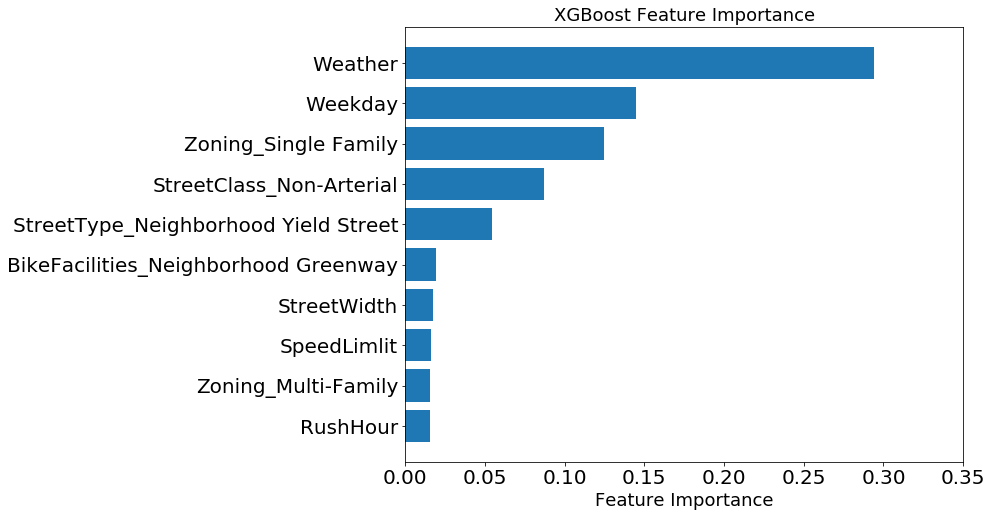

In [176]:


feat_imp = pd.DataFrame({
    'Feature': featurename[np.argsort(f_imp)[-10:]],
    'Importance': np.sort(f_imp)[-10:]
}).sort_values('Importance', ascending=False)

plt.rc('font', size=20)  
plt.figure(figsize=(10,8))
plt.barh(y = feat_imp['Feature'], width=feat_imp['Importance'][-10:])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance',  fontsize=18)
plt.xticks(np.arange(0, 0.40, 0.05))
plt.title('XGBoost Feature Importance', fontsize=18)
#plt.savefig('Feature Importance_xgboost.png')

In [558]:
#from sklearn.inspection.partial_dependence import plot_partial_dependence
#from sklearn.inspection.partial_dependence import partial_dependence
from pdpbox import pdp, get_dataset, info_plots

In [638]:
xg_beta['columntransformer'].transform(X_train).shape

(64261, 40)

In [643]:
cat_name  = xg_beta.named_steps['columntransformer'].transformers_[1][1].named_steps['onehot'].get_feature_names()
featurename = np.array(np.concatenate(( np.array(numeric_features), cat_name, ordinal_features)))
len(featurename)

40

In [676]:
featurename

array(['SEGLENGTH_log', 'SURFACEWID_log', 'PVMTCONDIN', 'SLOPE_PCT',
       'SW_WIDTH', 'LENGTH_MIL', 'x0_Alley', 'x0_Downtown',
       'x0_Downtown Neighborhood', 'x0_Downtown Neighborhood Access',
       'x0_Industrial Access', 'x0_Minor Industrial Access',
       'x0_Neighborhood Corridor', 'x0_Neighborhood Yield Street',
       'x0_Urban Center Connector', 'x0_Urban Village Main',
       'x0_Urban Village Neighborhood',
       'x0_Urban Village Neighborhood Access', 'x1_ART', 'x1_MLTUSETRL',
       'x1_NON-ART', 'x2_In Street, Major Separation',
       'x2_In Street, Minor Separation', 'x2_Multi-use Trail',
       'x2_Neighborhood Greenway', 'x2_NoFacility', 'x2_Sharrow',
       'x3_Commercial/Mixed Use', 'x3_Downtown', 'x3_Major Institutions',
       'x3_Manufacturing/Industrial', 'x3_Master Planned Community',
       'x3_Multi-Family', 'x3_Single Family', 'SPEEDLIMIT', 'CONDITION',
       'ONEWAY', 'simulate_rushhour', 'simulate_weather',
       'simulate_weekday'], dtype=object)

In [647]:
X_train_2 = pd.DataFrame(xg_beta['columntransformer'].transform(X_train))

X_train_2.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39'] 

In [648]:
xg_beta['xgbclassifier'].predict(X_train_2)

array([0, 0, 0, ..., 0, 0, 0])

In [680]:
featurename[39]

'simulate_weekday'

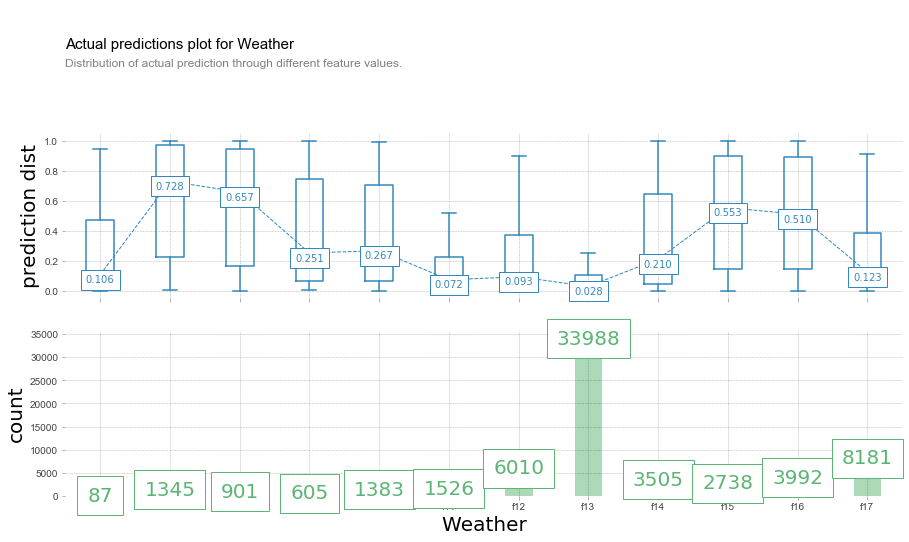

In [677]:
fig, axes, summary_df = info_plots.actual_plot(
model=xg_beta['xgbclassifier'], X=X_train_2, feature=['f6','f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17'], feature_name='Weather',predict_kwds={}
)

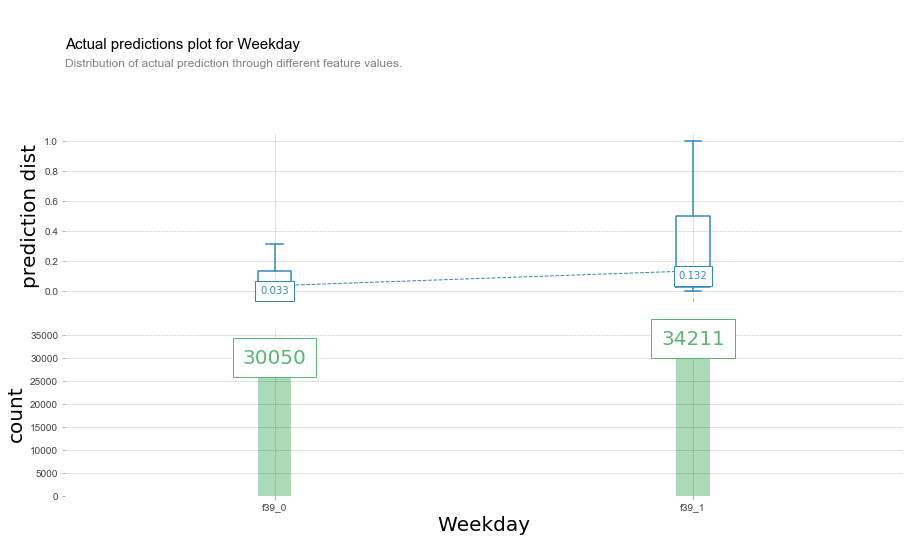

In [682]:
fig, axes, summary_df = info_plots.actual_plot(
model=xg_beta['xgbclassifier'], X=X_train_2, feature='f39', feature_name='Weekday',predict_kwds={}
)

In [277]:
X_both.groupby('EXISTING_FACILITY_TYPE').size()

EXISTING_FACILITY_TYPE
In Street, Major Separation     1163
In Street, Minor Separation     5206
Multi-use Trail                  919
Neighborhood Greenway           2909
NoFacility                     56309
Sharrow                         5190
dtype: int64

In [1796]:
X_both.columns

Index(['SEGLENGTH_log', 'SURFACEWID_log', 'PVMTCONDIN', 'PVMTCOND_1', 'SLOPE_PCT', 'SW_WIDTH', 'FILLERWID', 'MINIMUMVARIABLEWIDTH', 'PRIMARYCROSSSLOPE', 'LENGTH_MIL', 'SPEEDLIMIT', 'SEGDIR', 'STREETTYPE', 'ONEWAY', 'SURFACETYP', 'PVMTCATEGO', 'CONDITION', 'SWINCOMPLETEYN', 'simulate_rushhour', 'simulate_weather', 'simulate_weekday', 'EXISTING_FACILITY_TYPE', 'CLASS_DESC', 'GEN_ALIAS', 'SRTS_SIDEWALK_RANK', 'ARTCLASS'], dtype='object')

In [282]:
#!pip install graphviz
from xgboost import plot_tree
plot_tree(xg_beta.best_estimator_['xgbclassifier'])

In [288]:
# re_group variables , remove #ARTCLASS

numeric_features = ['SEGLENGTH_log','SURFACEWID_log', 'PVMTCONDIN','SLOPE_PCT' ,
                    'SW_WIDTH' ,'LENGTH_MIL']
#'ARTCLASS'
#'PVMTCOND_1', 'PRIMARYCROSSSLOPE','MINIMUMVARIABLEWIDTH','FILLERWID'
#categorical_features = ['ARTCLASS', 'SEGDIR', 'ONEWAY', 'SURFACETYP','NATIONHWYS' ,'PVMTCATEGO', 'PARKBOULEV' ,'TRANDESCRI', 'rushhour']
categorical_features = ['SPEEDLIMIT', 'CONDITION','ONEWAY',\
                   'simulate_rushhour','simulate_weather','simulate_weekday',\
                   'STREETTYPE', 'PVMTCATEGO',\
                    'EXISTING_FACILITY_TYPE','CLASS_DESC']
#'MATL' , 'FILLERTYPE', 'CURBTYPE','NATIONHWYS' ,'PARKBOULEV' , 'MINIMUMVARIABLEWIDTH' ,

In [289]:
##  XGboost ordinal variable for all categorical variables
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
## pre-processing 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())])

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgboost = make_pipeline(preprocessor,xgb_model)

params = {"learning_rate"    : [0.01, 0.05, 0.10, 0.15, 0.20 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] ,
         "reg_alpha"    : [ 1, 10, 100, 1000, 10000],
         "scale_pos_weight" : [8,10,12,15] }

new_params = {'xgbclassifier__' + key: params[key] for key in params}

ftwo_scorer = make_scorer(fbeta_score,beta = 2)
xg_ord_beta = RandomizedSearchCV(xgboost, param_distributions =new_params, cv=K_FOLD, scoring=ftwo_scorer, return_train_score=True, n_iter = 10)
xg_ord_beta.fit(X_train, y_train)
#xg_ord_all = RandomizedSearchCV(xgboost, param_distributions =new_params, cv=K_FOLD, scoring='recall', return_train_score=True, n_iter = 10)
#xg_ord_all.fit(X_train, y_train)


//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metric

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_ind

In [300]:
scores(xg_ord_beta , X_train, y_train)

64526
accuracy_score:  0.8455971236400831
recall_score:  0.8603921568627451
precision_score:  0.32172446660312337
 roc_auc_score:  0.8523597778222115


In [301]:
scores(xg_ord_beta , X_test, y_test)

7170
accuracy_score:  0.8323570432357044
recall_score:  0.8289241622574955
precision_score:  0.2984126984126984
 roc_auc_score:  0.8307879935927793


In [292]:
filename = './Results/xg_ord_beta.sav'
pickle.dump(xg_ord_beta.best_estimator_, open(filename, 'wb'))

In [17]:
#xg_ord_all = pickle.load(open(filename, 'rb'))

No Skill: ROC AUC=0.500
Model: ROC AUC=0.917


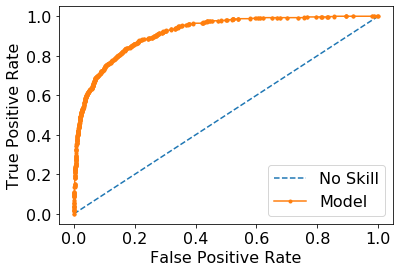

In [302]:
roc_plot(xg_ord_beta, X_test, y_test)
#plt.savefig('ROC_xgboost_ord.png')

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


No Skill: f1=0.000 auc=0.540
Model: f1=0.439 auc=0.587


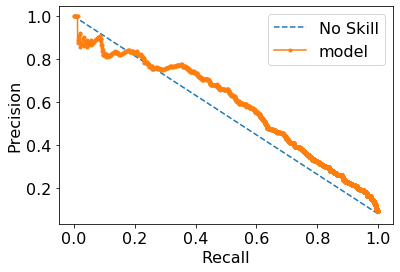

In [357]:
plot_PRCurve(xg_ord_beta, X_test, y_test)

In [294]:

featurename = np.array(np.concatenate(( np.array(numeric_features), categorical_features)))

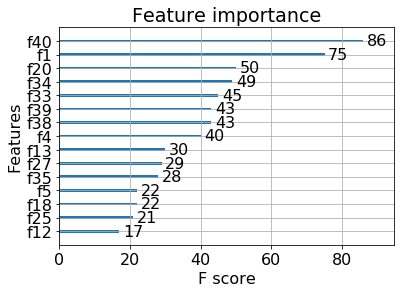

In [295]:
from xgboost import plot_importance 
plot_importance(grid_imba_ord.best_estimator_['xgbclassifier'],max_num_features = 15) #, 


In [303]:
f_imp = xg_ord_beta.best_estimator_['xgbclassifier'].feature_importances_

In [304]:
#f_imp

#for i in np.arange(0,len(featurename)):
#    featurename[i] = featurename[i].replace('x8_', 'RushHour_').replace('x9_', 'Weather_').\
#        replace('x10_', 'Weekday_').replace('x11_', 'Bike_Facility_').\
###        replace('x12_', 'Neighborhood_').replace('x13_', 'Zoning_').\
 #       replace('x0_', 'SpeedLimit_').replace('x1_', 'Direction_').replace('x2_', 'StreetType_').\
 #       replace('x3_', 'OneWay_').replace('x4_', 'Surface_').\
 #       replace('x5_', 'StreetClassification_').replace('x6_', 'Condition_').replace('x7_', 'SWIncomplete_')\
        
        
#print(featurename)


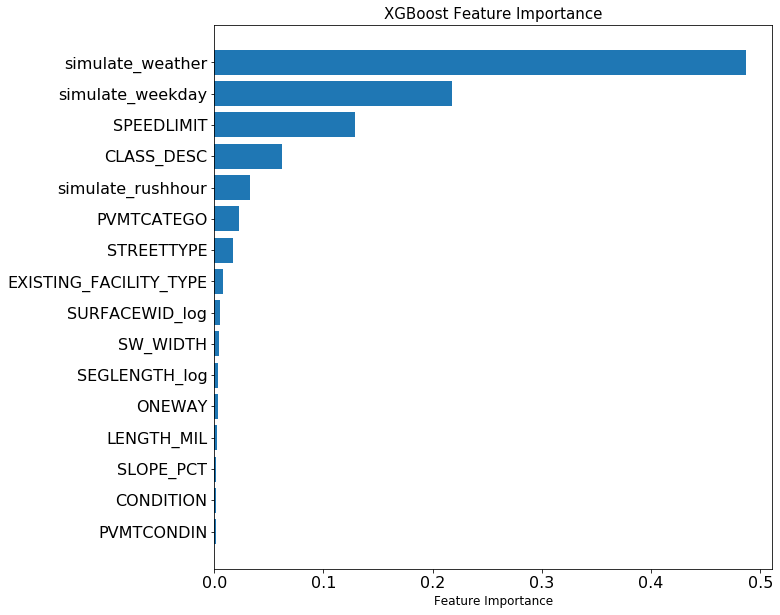

In [305]:
feat_imp = pd.DataFrame({
    'Feature': featurename[np.argsort(f_imp)[:]],
    'Importance': np.sort(f_imp)[:]
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,10))
plt.barh(y = feat_imp['Feature'], width=feat_imp['Importance'][:])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance',  fontsize=12)
plt.title('XGBoost Feature Importance', fontsize=15)
plt.savefig('Feature Importance_xgboost.png')

In [514]:
##XGBOOST with FEATURE SELECTION 

## try XGboost 
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
#xgboost = make_pipeline(preprocessor,xgb_model)
grid_imba4 = Pipeline(steps=[('preprocessor', preprocessor),
                          ('feature_selection', SelectFromModel(xgb.XGBClassifier(threshold = 0.01))),
                          ('classifier', xgb_model)])


#params0 = {"threshold" : [0.001, 0.01, 0.03, 0.05, 0.08, 0.1 ]  }

params = {"learning_rate"    : [0.01, 0.05, 0.10, 0.15, 0.20 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] ,
         "reg_alpha"    : [ 1, 10, 100, 1000, 10000],
         "scale_pos_weight" : [8,10,12,15] }

#new_params4 = dict({'selectfrommodel__' + key: params0[key] for key in params0})
#new_params4.update( {'classifier__' + key: params[key] for key in params}.items())

new_params4 = {'xgbclassifier__' + key: params[key] for key in params}

grid_imba4 = RandomizedSearchCV(xgboost, param_distributions =new_params4, cv=K_FOLD, scoring='recall', return_train_score=True, n_iter = 10)
grid_imba4.fit(X_train, y_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_ind

In [515]:
grid_imba4.best_estimator_.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                     transformer_weights=None,
                     transformers=[('num',
                                    Pipeline(memory=None,
                                             steps=[('imputer',
                                                     SimpleImputer(add_indicator=False,
                                                                   copy=True,
                                                                   fill_value=None,
                                                                   missing_values=nan,
                                                                   strategy='median',
                                                                   verbose=0)),
                                                    ('scaler',
                                                     StandardScaler(copy=True,
                   

In [1285]:
grid_imba4.best_estimator_

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

In [953]:
featurename = np.array(np.concatenate(( np.array(numeric_features), categorical_features)))
f_imp = grid_imba4.best_estimator_['xgbclassifier'].feature_importances_

Text(0.5, 1.0, 'XGBoost feature importance')

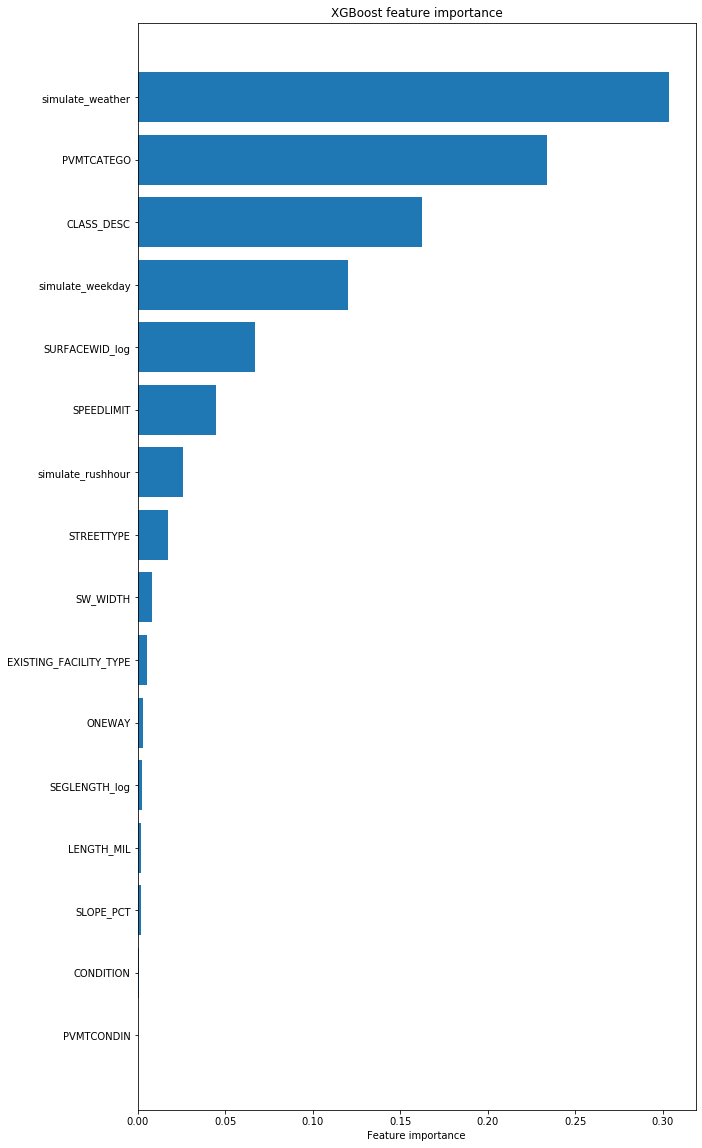

In [1623]:
feat_imp = pd.DataFrame({
    'Feature': featurename [np.argsort(f_imp)],
    'Importance': np.sort(f_imp)
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,20))
plt.barh(y = feat_imp['Feature'], width=feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature importance')
plt.title('XGBoost feature importance')
#plt.savefig("fig/rf_feat_importance.png", bbox_inches='tight')

In [952]:
grid_imba4.best_score_

0.860980175515842

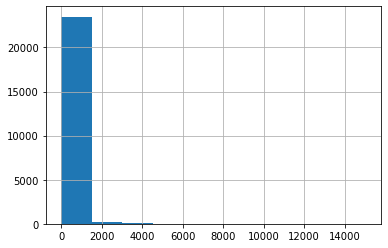

In [955]:
street['SHAPE_Leng'].hist()

In [964]:
sum(street['SHAPE_Leng']> 850)/len(street)

0.04486829391253203

In [968]:
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, precision_score,roc_auc_score

_y_prediction = grid_imba4.predict(X_test)
print(len(_y_prediction))
print(accuracy_score(y_test,_y_prediction))
print(recall_score(y_test,_y_prediction))
print(precision_score(y_test,_y_prediction))
print(roc_auc_score(y_test,_y_prediction))

7141
0.7927461139896373
0.8571428571428571
0.25782493368700266
0.822167412751532


In [969]:
## try XGboost 
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgboost = make_pipeline(preprocessor,xgb_model)

params = {"learning_rate"    : [0.01, 0.05, 0.10, 0.15, 0.20 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] ,
         "reg_alpha"    : [ 1, 10, 100, 1000, 10000],
         "scale_pos_weight" : [8,10,12,15] }

new_params = {'xgbclassifier__' + key: params[key] for key in params}


grid_imba5 = RandomizedSearchCV(xgboost, param_distributions =new_params, cv=K_FOLD, scoring='accuracy', return_train_score=True, n_iter = 10)
grid_imba5.fit(X_train, y_train)




RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_ind

In [971]:
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, precision_score,roc_auc_score

_y_prediction = grid_imba5.predict(X_train)
print(len(_y_prediction))
print(accuracy_score(y_train,_y_prediction))
print(recall_score(y_train,_y_prediction))
print(precision_score(y_train,_y_prediction))
print(roc_auc_score(y_train,_y_prediction))

64261
0.9318871477256812
0.953921568627451
0.5401354502053958
0.9419546147087493


In [974]:
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, precision_score,roc_auc_score

_y_prediction = grid_imba5.predict(X_test)
print(len(y_test))
print(accuracy_score(y_test,_y_prediction))
print(recall_score(y_test,_y_prediction))
print(precision_score(y_test,_y_prediction))
print(roc_auc_score(y_test,_y_prediction))

7141
0.9021145497829436
0.7848324514991182
0.4354207436399217
0.8485312242284153


# Random forest

In [370]:
# re_group variables , remove #ARTCLASS

numeric_features = ['SEGLENGTH_log','SURFACEWID_log', 'PVMTCONDIN','SLOPE_PCT' ,
                    'SW_WIDTH' ,'LENGTH_MIL']
#'ARTCLASS'
#'PVMTCOND_1', 'PRIMARYCROSSSLOPE','MINIMUMVARIABLEWIDTH','FILLERWID'
#categorical_features = ['ARTCLASS', 'SEGDIR', 'ONEWAY', 'SURFACETYP','NATIONHWYS' ,'PVMTCATEGO', 'PARKBOULEV' ,'TRANDESCRI', 'rushhour']
categorical_features = ['STREETTYPE', 'PVMTCATEGO',\
                        'EXISTING_FACILITY_TYPE','CLASS_DESC']
ordinal_features = ['SPEEDLIMIT', 'CONDITION','ONEWAY',\
                   'simulate_rushhour','simulate_weather','simulate_weekday']
#'MATL' , 'FILLERTYPE', 'CURBTYPE','NATIONHWYS' ,'PARKBOULEV' , 'MINIMUMVARIABLEWIDTH' ,

In [371]:
## Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
#from preprocessing import OrdinalEncoder
## Random Oversampler 
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss
#sm= SMOTE() #ratio = RATIO
#nm = NearMiss(sampling_strategy = 'majority')

## pre-processing 


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())])

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])



clf = RandomForestClassifier(class_weight = 'balanced')
rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', clf)])

## cross validate 
#from sklearn.model_selection import cross_validate

#scores = cross_validate(rf, X_train, y_train, scoring=['roc_auc','recall','accuracy','precision', 'f1'], cv = K_FOLD, return_train_score = True, return_estimator=True)

In [287]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12,15,20],
}
new_params = {'classifier__' + key: params[key] for key in params}

ftwo_scorer = make_scorer(fbeta_score,beta = 2)
rf_beta = RandomizedSearchCV(rf , param_distributions =new_params, cv=K_FOLD, scoring=ftwo_scorer, return_train_score=True, n_iter = 10)
rf_beta.fit(X_train, y_train)

#rf_grid = RandomizedSearchCV(rf, param_distributions =new_params, cv=K_FOLD, scoring='recall', return_train_score=True, n_iter = 10)
#rf_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicato

In [307]:
scores(rf_beta, X_train, y_train)

64526
accuracy_score:  0.9014040851749683
recall_score:  0.8862745098039215
precision_score:  0.43874975732867405
 roc_auc_score:  0.8944885152930354


In [308]:
scores(rf_beta, X_test, y_test)

7170
accuracy_score:  0.8769874476987448
recall_score:  0.763668430335097
precision_score:  0.36663844199830653
 roc_auc_score:  0.8251932943739697


In [320]:
cat_name  = rf_beta.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names()
featurename = np.array(np.concatenate(( np.array(numeric_features), cat_name, ordinal_features)))

In [321]:
f_imp = rf_beta.best_estimator_['classifier'].feature_importances_
len(featurename)

40

In [312]:
#cat_name = grid_imba.best_estimator_.named_steps['columntransformer'].transformers_[1][1].named_steps['onehot'].get_feature_names()



In [313]:
rf_beta.best_params_

{'classifier__n_estimators': 200, 'classifier__max_depth': 12}

In [315]:
rf_beta.best_score_

0.6420558037344841

In [318]:
_y_prediction = rf_beta.predict(X_train)

Text(0.5, 1.0, 'Random forest feature importance')

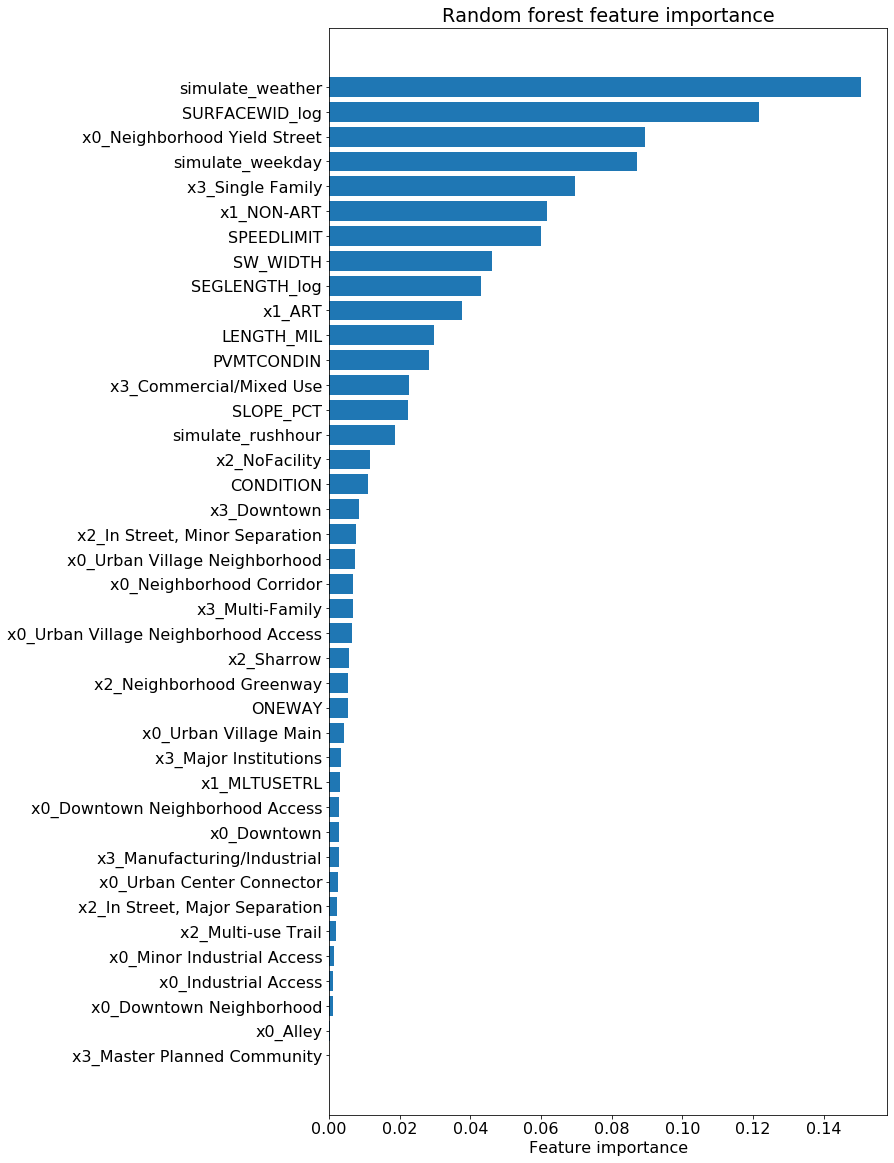

In [372]:
feat_imp = pd.DataFrame({
    'Feature': featurename [np.argsort(f_imp)],
    'Importance': np.sort(f_imp)
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,20))
plt.barh(y = feat_imp['Feature'], width=feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature importance')
plt.title('Random forest feature importance')
#plt.savefig("fig/rf_feat_importance.png", bbox_inches='tight')

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


No Skill: f1=0.000 auc=0.540
Model: f1=0.495 auc=0.623


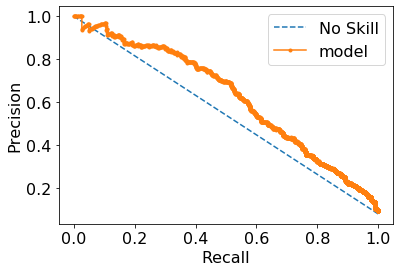

In [323]:
plot_PRCurve(rf_beta, X_test, y_test)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.918


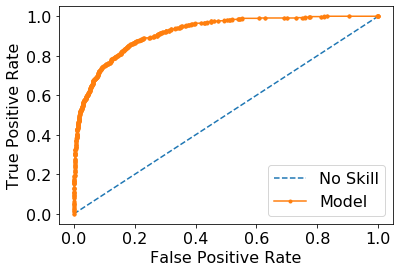

In [324]:
roc_plot(rf_beta, X_test, y_test)

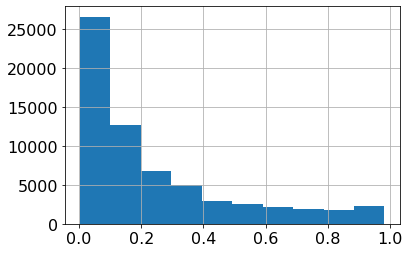

In [385]:
pd.Series(rf_beta.best_estimator_['classifier'].predict_proba(rf_beta.best_estimator_['preprocessor'].transform(X_train))[:,1]).hist()

In [386]:
learning_curve(rf_beta.best_estimator_['classifier'], rf_beta.best_estimator_['preprocessor'].transform(X_train), y_train, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


(array([ 4301, 13980, 23659, 33338, 43017]),
 array([[0.97395954, 0.97535457, 0.97651709],
        [0.9472103 , 0.94434907, 0.94463519],
        [0.93431675, 0.93106218, 0.92763853],
        [0.92126102, 0.921441  , 0.92123103],
        [0.91175582, 0.9121975 , 0.9142897 ]]),
 array([[0.92319494, 0.92775117, 0.92956109],
        [0.91092101, 0.91357106, 0.9131486 ],
        [0.90278488, 0.90748059, 0.90194346],
        [0.89423032, 0.90162258, 0.89947926],
        [0.88762843, 0.89525315, 0.89320253]]))

<module 'matplotlib.pyplot' from '//anaconda3/envs/bike/lib/python3.7/site-packages/matplotlib/pyplot.py'>

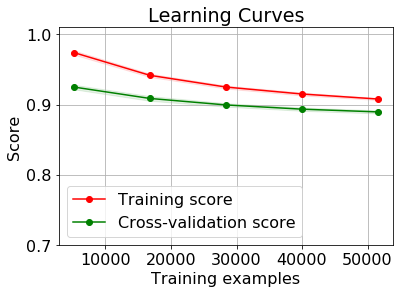

In [407]:
from sklearn.model_selection import StratifiedShuffleSplit
title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

plot_learning_curve(rf_beta.best_estimator_['classifier'], title, rf_beta.best_estimator_['preprocessor'].transform(X_train), y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [867]:
## Random Forest with undersampling Nearmiss
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
#from preprocessing import OrdinalEncoder
## Random Oversampler 
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss
#sm= SMOTE() #ratio = RATIO
nm = NearMiss(sampling_strategy = 'majority')

## pre-processing 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder())])

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


clf = RandomForestClassifier()
rf = make_pipeline(preprocessor,nm ,clf)


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
}
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba2 = RandomizedSearchCV(rf, param_distributions =new_params, cv=K_FOLD, scoring='recall', return_train_score=True, n_iter = 10)
grid_imba2.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_ind

In [893]:
grid_imba2.best_params_


{'randomforestclassifier__n_estimators': 200,
 'randomforestclassifier__max_depth': 4}

In [894]:
grid_imba2.best_score_

0.8843136034389169

In [436]:
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, precision_score,roc_auc_score

_y_prediction = grid_imba2.predict(X_train)

print(accuracy_score(y_train,_y_prediction))
print(recall_score(y_train,_y_prediction))
print(precision_score(y_train,_y_prediction))
print(roc_auc_score(y_train,_y_prediction))

0.7156906988686762
0.8774509803921569
0.20230560578661844
0.7895985315577863


In [ ]:
# Try Oversampling 

In [203]:
## Random Oversampler 
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss
sm= SMOTE() #ratio = RATIO

In [259]:
# re_group variables , remove #ARTCLASS

numeric_features = ['SEGLENGTH_log','SURFACEWID_log', 'PVMTCONDIN','SLOPE_PCT' ,
                    'SW_WIDTH' ,'LENGTH_MIL']
#'ARTCLASS'
#'PVMTCOND_1', 'PRIMARYCROSSSLOPE','MINIMUMVARIABLEWIDTH','FILLERWID'
#categorical_features = ['ARTCLASS', 'SEGDIR', 'ONEWAY', 'SURFACETYP','NATIONHWYS' ,'PVMTCATEGO', 'PARKBOULEV' ,'TRANDESCRI', 'rushhour']
categorical_features = ['STREETTYPE', 'PVMTCATEGO',\
                        'EXISTING_FACILITY_TYPE','CLASS_DESC']
ordinal_features = ['SPEEDLIMIT', 'CONDITION','ONEWAY',\
                   'simulate_rushhour','simulate_weather','simulate_weekday']
#'MATL' , 'FILLERTYPE', 'CURBTYPE','NATIONHWYS' ,'PARKBOULEV' , 'MINIMUMVARIABLEWIDTH' ,

In [260]:
##  XGboost ordinal variable ,remove #ARTCLASS
import xgboost as xgb
from sklearn.metrics import make_scorer, fbeta_score
## pre-processing 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())])

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgboost = make_pipeline(preprocessor,xgb_model)

params = {"learning_rate"    : [0.01, 0.05, 0.10, 0.15, 0.20 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] ,
         "reg_alpha"    : [ 1, 10, 100, 1000, 10000],
         "scale_pos_weight" : [8,10,12,15] }

new_params = {'xgbclassifier__' + key: params[key] for key in params}




In [207]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xg_sm = make_pipeline(preprocessor,sm, xgb_model)

In [213]:
ftwo_scorer = make_scorer(fbeta_score,beta = 2)
xg_sm= RandomizedSearchCV(xg_sm, param_distributions =new_params, cv=K_FOLD, scoring=ftwo_scorer, return_train_score=True, n_iter = 10)
xg_sm.fit(X_train, y_train)

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indic

In [214]:
scores(xg_sm, X_test, y_test)

7141
accuracy_score:  0.7809830555944546
recall_score:  0.9012345679012346
precision_score:  0.2530955918771669
roc_auc_score:  0.83592303387456


In [248]:
filename = './Results/xg_smote.sav'
pickle.dump(xg_sm.best_estimator_, open(filename, 'wb'))

#xg_beta = pickle.load(open(filename, 'rb'))

In [258]:
np.sum(xg_beta.predict(X_test))/len(X_test)

0.16790365495028708

In [304]:
# re_group variables , remove #ARTCLASS

numeric_features = ['SEGLENGTH_log','SURFACEWID_log', 'PVMTCONDIN','SLOPE_PCT' ,
                    'SW_WIDTH' ,'LENGTH_MIL']
#'ARTCLASS'
#'PVMTCOND_1', 'PRIMARYCROSSSLOPE','MINIMUMVARIABLEWIDTH','FILLERWID'
#categorical_features = ['ARTCLASS', 'SEGDIR', 'ONEWAY', 'SURFACETYP','NATIONHWYS' ,'PVMTCATEGO', 'PARKBOULEV' ,'TRANDESCRI', 'rushhour']
categorical_features = ['STREETTYPE', 'PVMTCATEGO',\
                        'EXISTING_FACILITY_TYPE','CLASS_DESC']
ordinal_features = ['SPEEDLIMIT', 'CONDITION','ONEWAY',\
                   'simulate_rushhour','simulate_weather','simulate_weekday']
#'MATL' , 'FILLERTYPE', 'CURBTYPE','NATIONHWYS' ,'PARKBOULEV' , 'MINIMUMVARIABLEWIDTH' ,

In [307]:


##  XGboost ordinal variable ,remove #ARTCLASS
import xgboost as xgb
from sklearn.metrics import make_scorer, fbeta_score
## pre-processing 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())])

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

params = {"learning_rate"    : [0.01, 0.05, 0.10, 0.15, 0.20 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] ,
         "reg_alpha"    : [ 1, 10, 100, 1000, 10000],
         "scale_pos_weight" : [8,10,12,15] }

new_params = {'xgbclassifier__' + key: params[key] for key in params}



In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
ros= RandomOverSampler()
xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xg_ros = make_pipeline(preprocessor,ros, xgb_model)
ftwo_scorer = make_scorer(fbeta_score,beta = 2)
xgbros = RandomizedSearchCV(xg_ros, param_distributions =new_params, cv=K_FOLD, scoring=ftwo_scorer, return_train_score=True, n_iter = 10)
xgbros.fit(X_train, y_train)

In [318]:
tuned_parameters =  {'kernel': ['linear'], 'C': [0.1,1, 10, 100, 1000]}
new_params = {'clf__' + key: tuned_parameters[key] for key in tuned_parameters}
new_params

{'clf__kernel': ['linear'], 'clf__C': [0.1, 1, 10, 100, 1000]}

In [319]:
{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},

({'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]},)

In [ ]:
from sklearn import svm

pipe_svm = Pipeline([('preprocessor', preprocessor),('clf', svm.SVC(kernel = 'rbf', random_state=42))])

ftwo_scorer = make_scorer(fbeta_score,beta = 2)
xg_sm= RandomizedSearchCV(pipe_svm, param_distributions =new_params, cv=K_FOLD, scoring=ftwo_scorer, return_train_score=True, n_iter = 10)
xg_sm.fit(X_train, y_train)

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted'

//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/bike/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exampl